In [1]:
import os
import mne
import numpy as np
import joblib
from scipy import stats
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def load_sleep_data(data_dir):                                              # Sleep-EDF icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                          # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('0-PSG.edf'):
            hyp_file = f.replace('0-PSG.edf', 'C-Hypnogram.edf')
            if os.path.exists(os.path.join(data_dir, hyp_file)):            # Ayni konuya ait PSG ve Hypnogram dosyalarini eslestiriyoruz.
                file_pairs.append((                                         # PSG dosyasi sinyalleri tutar ve Hypnogram dosyasi labellari tutar.
                    os.path.join(data_dir, f),
                    os.path.join(data_dir, hyp_file)
                ))
    
    print(f"Bulunan PSG-Hypnogram çiftleri: {len(file_pairs)}")
    return file_pairs

In [3]:
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, kurtosis, skew, iqr

def bandpower(psd, freqs, fmin, fmax):
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band])

def extract_features_multi(data, sfreq, n_fft_comp=5):
    feature_list = []
    count = 0
    
    # Zaman serisinde ozellik cikarimi yapiyorum. Buradaki ozniteliklerin cogunu TSFEL: Time Series Feature Extraction Library makalesinden aldim.

    for epoch in data:
        feats = []
        for ch_signal in epoch:
            t = np.arange(len(ch_signal))
            abs_energy = np.sum(ch_signal**2)                                                           # Sinyalin toplam enerjisi, guc olcusu
            area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri
            
            autocorr = np.corrcoef(ch_signal[:-1], ch_signal[1:])[0, 1] if np.std(ch_signal) > 0 else 0 # Sinyalin kendisiyle bir gecikmeyle olan korelasyonu
            
            avg_power = np.mean(ch_signal**2)                                                           # Ortalama guc
            centroid = np.sum(t * np.abs(ch_signal)) / (np.sum(np.abs(ch_signal)) + 1e-12)              # Sinyal agirlik merkezi
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)
            hist_entropy = entropy(hist + 1e-12)                                                        # Sinyal genlik dagiliminin duzensizligi
            
            freqs, psd = welch(ch_signal, sfreq, nperseg=min(256, len(ch_signal)))
            psd /= np.sum(psd) + 1e-12                                                                  # Frekanslara gore enerji dagilimi
            
            fund_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0                                    # En yuksek guce sahip frekans bileşeni
            
            hist_vals, hist_bins = np.histogram(ch_signal, bins=10)
            hist_mode = hist_bins[np.argmax(hist_vals)]                                                 # En cok gorulen genlik degeri
            
            human_energy = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])                                  # Insan EEG bandindaki enerji
            iqr_val = iqr(ch_signal)                                                                    # Sinyalin orta %50'sinin yayilimi
            kurt_val = kurtosis(ch_signal)                                                              # Carpiklik, uc deger yogunlugu
            
            max_val = np.max(ch_signal)                                                                 # Maksimum deger
            max_psd = np.max(psd)                                                                       # Maksimum guc
            max_freq = freqs[-1]                                                                        # En yuksek olculebilir frekans
            
            mean_val = np.mean(ch_signal)                                                               # Ortalama deger
            mad = np.mean(np.abs(ch_signal - mean_val))                                                 # Ortalama mutlak sapma
            mean_abs_diff = np.mean(np.abs(np.diff(ch_signal)))                                         # Komşu ornekler arasindaki ortalama mutlak fark
            mean_diff = np.mean(np.diff(ch_signal))                                                     # Komşu ornekler arasindaki ortalama fark
            
            med_val = np.median(ch_signal)                                                              # Medyan deger
            med_abs_dev = np.median(np.abs(ch_signal - med_val))                                        # Medyan mutlak sapma
            med_abs_diff = np.median(np.abs(np.diff(ch_signal)))                                        # Medyan komşu mutlak farki
            med_diff = np.median(np.diff(ch_signal))                                                    # Medyan komşu farki
            cumulative_power = np.cumsum(psd)
            med_freq = freqs[np.argmax(cumulative_power >= 0.5)] if len(psd) > 0 else 0                 # Medyan frekans
            
            min_val = np.min(ch_signal)                                                                 # Minimum deger
            
            diff_signal = np.diff(ch_signal)
            sign_changes = np.diff(np.sign(diff_signal))
            neg_turning = np.sum(sign_changes > 0)                                                      # Negatif egimden pozitif egime geciş sayisi
            pos_turning = np.sum(sign_changes < 0)                                                      # Pozitif egimden negatif egime geciş sayisi
            peaks, _ = find_peaks(ch_signal)
            n_peaks = len(peaks)                                                                        # Tepe sayisi
            peak_dist = np.mean(np.diff(peaks)) if n_peaks > 1 else 0                                   # Tepeler arasi ortalama mesafe
            
            if len(psd) > 0:
                peak_psd = np.max(psd)
                mask = psd >= (peak_psd / 2)
                try:
                    power_bandwidth = freqs[mask][-1] - freqs[mask][0]                                  # Gucun %50'sinden fazlasini iceren frekans araligi
                except:
                    power_bandwidth = 0
            else:
                power_bandwidth = 0
                
            rms = np.sqrt(avg_power)                                                                    
            signal_dist = np.sum(np.abs(ch_signal))                                                     # Mutlak genlik toplami
            skew_val = skew(ch_signal)                                                                  # Simetri olcusu
            slope = np.polyfit(t, ch_signal, 1)[0]                                                      # Lineer egim, trend
            
            spec_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-12)                                 # Spektral agirlik merkezi
            spec_decrease = np.sum((psd[1:] - psd[0]) / np.arange(1, len(psd))) / (np.sum(psd[1:]) + 1e-12) if len(psd) > 1 else 0   # Yuksek frekanslardaki guc kaybi
            spec_ent = entropy(psd + 1e-12)                                                             # Spektral entropi
            spec_kurt = kurtosis(psd)                                                                   # Spektral carpiklik
            diff_psd = np.diff(psd)
            psd_sign_changes = np.diff(np.sign(diff_psd))
            spec_pos_turning = np.sum(psd_sign_changes < 0)                                             # Spektral donuş noktasi sayisi
            spec_roll_off = freqs[np.argmax(cumulative_power >= 0.85)] if len(psd) > 0 else 0           # Enerjinin %85'ine ulaşilan frekans
            spec_roll_on = freqs[np.argmax(cumulative_power >= 0.05)] if len(psd) > 0 else 0            # Enerjinin %5'ine ulaşilan frekans
            spec_skew = skew(psd)                                                                       # Spektral skewness
            spec_slope = np.polyfit(freqs, psd, 1)[0] if len(psd) > 1 else 0                            # Spektral egim
            spec_spread = np.sqrt(np.sum(psd * (freqs - spec_centroid)**2) / (np.sum(psd) + 1e-12))     # Spektral yayilma
            
            std = np.std(ch_signal)                                                                     # Standart sapma
            sum_abs_diff = np.sum(np.abs(np.diff(ch_signal)))                                           # Ornekler arasi toplam fark
            var = np.var(ch_signal)                                                                     # Varyans
            
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            zcr = zero_crossings / len(ch_signal)                                                       # Sinyalin kac kez sifiri gectigi

            bp_delta = bandpower(psd, freqs, 0.5, 4)                                                    # Bant güçleri (delta: 0.5–4Hz, theta: 4–8Hz, alpha: 8–13Hz, beta: 13–30Hz, gamma: 30–40Hz)
            bp_theta = bandpower(psd, freqs, 4, 8)
            bp_alpha = bandpower(psd, freqs, 8, 13)
            bp_beta  = bandpower(psd, freqs, 13, 30)
            bp_gamma = bandpower(psd, freqs, 30, 40)
            
            fft_vals = np.fft.rfft(ch_signal)                                                           # FFT bileşenleri (en büyük n_fft_comp genlik)
            fft_power = np.abs(fft_vals)
            top_fft_indices = np.argsort(fft_power)[-n_fft_comp:][::-1]
            top_fft_components = fft_power[top_fft_indices]

            features = [
                abs_energy, area_curve, autocorr, avg_power, centroid, hist_entropy,
                fund_freq, hist_mode, human_energy, iqr_val, kurt_val, max_val,
                bp_delta, bp_theta, bp_alpha, bp_beta, bp_gamma, *top_fft_components,
                max_psd, max_freq, mean_val, mad, mean_abs_diff, mean_diff, med_val,
                med_abs_dev, med_abs_diff, med_diff, med_freq, min_val, neg_turning,
                n_peaks, peak_dist, pos_turning, power_bandwidth, rms, signal_dist,
                skew_val, slope, spec_centroid, spec_decrease, spec_ent,
                spec_kurt, spec_pos_turning, spec_roll_off, spec_roll_on, spec_skew,
                spec_slope, spec_spread, std, sum_abs_diff, var, zcr
            ]
            
            feats.extend(features)
            
        feature_list.append(feats)
        count += 1
        
    print(f"Özellik çıkarımı için toplam {count} epoch işlendi.")
    return np.array(feature_list)

In [4]:
def create_sequences(data, labels, seq_length=10):                                                      # Zaman serisi verileri olusturuyorum.
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length-1])
    return np.array(X), np.array(y)

In [5]:

def create_dataset(file_pairs, epoch_duration=30.0, seq_length=10):
    base_event_id = {
        'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
        'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
    }
    all_sequences = []
    all_labels = []
    
    for psg_file, hyp_file in file_pairs:                                                               # Her PSG-Hypnogram dosya cifti icin yukleme dongusu
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annots = mne.read_annotations(hyp_file)
        raw.set_annotations(annots, emit_warning=False)

        descs = set(str(d) for d in annots.description)                                                 # O anda bulunan descriptionlari aliyorum.
        event_id = {k: v for k, v in base_event_id.items() if k in descs}                               # Sadece dosyada olanları event_id'ye aliyorum.
        if not event_id:
            continue

        events, _ = mne.events_from_annotations(                                                        # Anotasyonlardan epoch eventlerini olusturuyorum.
            raw, event_id=event_id, chunk_duration=epoch_duration
        )
        if len(events) == 0:
            continue

        epochs = mne.Epochs(
            raw, events, event_id=event_id,
            tmin=0.0, tmax=epoch_duration - 1/raw.info['sfreq'],                                        # Her epochun sonu 
            baseline=None, preload=True
        )
        data = epochs.get_data()
        feats = extract_features_multi(data, raw.info['sfreq'])                                         # Her epoch icin ozellik cikariyorum ve ozellikleri ve etiketleri listeye ekliyorum.
        labels = epochs.events[:, -1]
        
        sequences, seq_labels = create_sequences(feats, labels, seq_length)                             # Zaman serisi olusturuyorum.
        if len(sequences) > 0:
            all_sequences.append(sequences)
            all_labels.append(seq_labels)
    
    X = np.vstack(all_sequences) if all_sequences else np.array([])                                     # Tum dosyalarin ozelliklerini ve etiketlerini birlestiriyorum.
    y = np.hstack(all_labels) if all_labels else np.array([])
    return X, y

Bulunan PSG-Hypnogram çiftleri: 5


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
2857 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2857 events and 3000 original time points ...
0 bad epochs dropped


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\571596984.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri


Özellik çıkarımı için toplam 2857 epoch işlendi.


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
2641 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2641 events and 3000 original time points ...
0 bad epochs dropped


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\571596984.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri


Özellik çıkarımı için toplam 2641 epoch işlendi.


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
2780 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2780 events and 3000 original time points ...
0 bad epochs dropped


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\571596984.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri


Özellik çıkarımı için toplam 2780 epoch işlendi.


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
2685 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2685 events and 3000 original time points ...
0 bad epochs dropped


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\571596984.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri


Özellik çıkarımı için toplam 2685 epoch işlendi.


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\803434448.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
2814 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2814 events and 3000 original time points ...
0 bad epochs dropped


C:\Users\EgeTERZI\AppData\Local\Temp\ipykernel_8008\571596984.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri


Özellik çıkarımı için toplam 2814 epoch işlendi.
X_test shape: (13727, 10, 399) y_test shape: (13727,)


Test verisi boyut (özellik seçimi sonrası): (13727, 10, 175)


429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

RNN Performans:
Accuracy: 0.5215
Macro F1: 0.4322
Cohen's Kappa: 0.3309
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.97      0.41      0.58      9552
          N1       0.08      0.38      0.13       253
          N2       0.42      0.84      0.56      2465
          N3       0.19      0.81      0.31       519
         REM       0.51      0.70      0.59       938

    accuracy                           0.52     13727
   macro avg       0.43      0.63      0.43     13727
weighted avg       0.79      0.52      0.56     13727



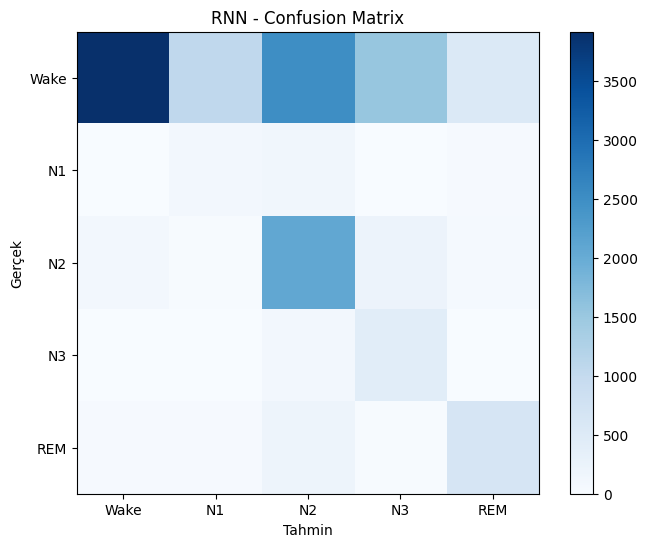

429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

LSTM Performans:
Accuracy: 0.7699
Macro F1: 0.5888
Cohen's Kappa: 0.5816
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.96      0.79      0.86      9552
          N1       0.19      0.40      0.25       253
          N2       0.57      0.81      0.67      2465
          N3       0.39      0.88      0.54       519
         REM       0.71      0.54      0.61       938

    accuracy                           0.77     13727
   macro avg       0.56      0.68      0.59     13727
weighted avg       0.84      0.77      0.79     13727



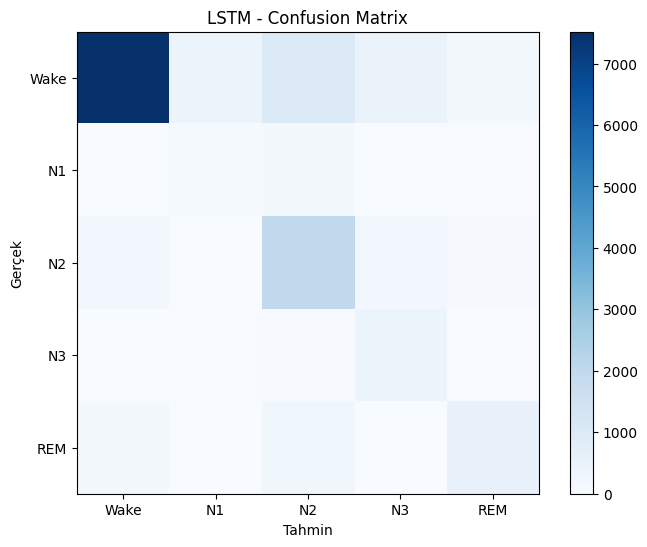

429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

GRU Performans:
Accuracy: 0.8275
Macro F1: 0.6193
Cohen's Kappa: 0.6676
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.98      0.87      0.92      9552
          N1       0.29      0.23      0.26       253
          N2       0.60      0.84      0.70      2465
          N3       0.40      0.86      0.55       519
         REM       0.97      0.51      0.67       938

    accuracy                           0.83     13727
   macro avg       0.65      0.66      0.62     13727
weighted avg       0.88      0.83      0.84     13727



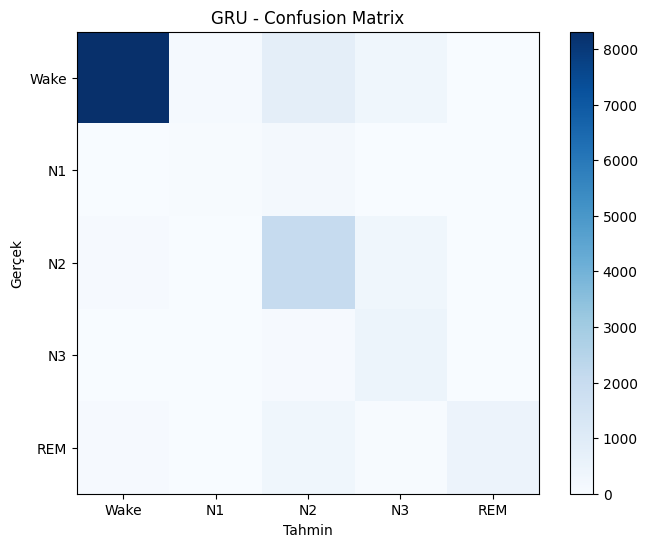

429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Transformer Performans:
Accuracy: 0.8768
Macro F1: 0.6548
Cohen's Kappa: 0.7401
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.96      0.96      0.96      9552
          N1       0.25      0.38      0.30       253
          N2       0.71      0.83      0.77      2465
          N3       0.75      0.46      0.57       519
         REM       0.86      0.56      0.68       938

    accuracy                           0.88     13727
   macro avg       0.71      0.64      0.65     13727
weighted avg       0.89      0.88      0.88     13727



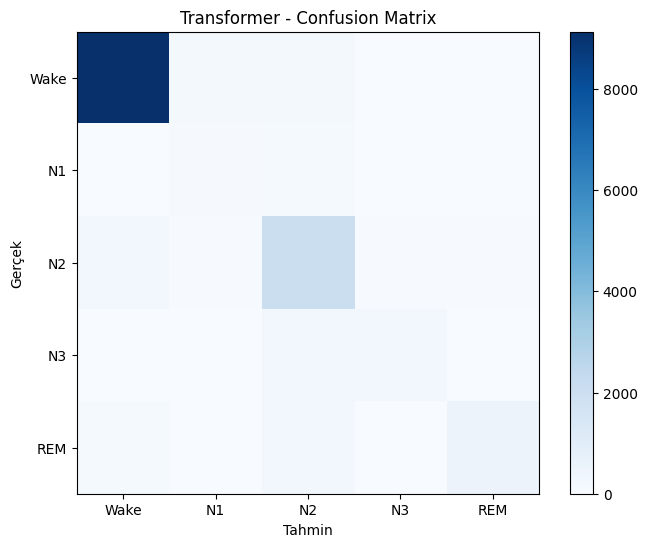


MODEL PERFORMANS KARŞILAŞTIRMASI:
RNN: Accuracy=0.5215, F1=0.4322, Kappa=0.3309
LSTM: Accuracy=0.7699, F1=0.5888, Kappa=0.5816
GRU: Accuracy=0.8275, F1=0.6193, Kappa=0.6676
Transformer: Accuracy=0.8768, F1=0.6548, Kappa=0.7401


In [6]:
def evaluate_model(y_true, y_pred, name):                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                       # Cohen Kappa skoru
    
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, target_names=['Wake', 'N1', 'N2', 'N3', 'REM']))
    
    cm = confusion_matrix(y_true, y_pred)                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.yticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
    
    return acc, f1, kappa


def main():

    DATA_DIR = "./SleepData/Sleep_EDF_Testing_Data"
    SEQ_LENGTH = 10                                                                 # Egitimle ayni degeri kullaniyorum.
    
    file_pairs = load_sleep_data(DATA_DIR)                                          # Veriyi yukluyorum ve verisetini olusturuyorum.
    X_test, y_test = create_dataset(file_pairs, epoch_duration=30.0, seq_length=SEQ_LENGTH)
    
    if len(X_test) == 0:
        print("Test verisi bulunamadı!")
        return
    
    print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
    

    scaler = joblib.load('scaler.joblib')                                           # Veriyi olceklendiriyorum, ve secilmis K tane ozellige gore filtreliyorum.
    selector = joblib.load('selector.joblib')
    selected_indices = joblib.load('selected_indices.joblib')
    n_samples, seq_len, n_features = X_test.shape
    X_flat = X_test.reshape(-1, n_features)
    X_flat_scaled = scaler.transform(X_flat)
    X_scaled = X_flat_scaled.reshape(n_samples, seq_len, n_features)
    
    X_selected = X_scaled[:, :, selected_indices]
    print(f"Test verisi boyut (özellik seçimi sonrası): {X_selected.shape}")


    models = {                                                                      # Modelleri yukluyorum.
        'RNN': load_model('rnn_model.h5'),
        'LSTM': load_model('lstm_model.h5'),
        'GRU': load_model('gru_model.h5'),
        'Transformer': load_model('transformer_model.keras')
    }
    
    results = {}
    
    for name, model in models.items():                                              # Her bir model icin tahmin ve degerlendirme yapiyorum.
        y_pred = np.argmax(model.predict(X_selected), axis=1)
        metrics = evaluate_model(y_test, y_pred, name)
        results[name] = metrics
    
    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")                                    # Performans karsilastirmasi yapiyorum.
    for name, metrics in results.items():
        print(f"{name}: Accuracy={metrics[0]:.4f}, F1={metrics[1]:.4f}, Kappa={metrics[2]:.4f}")

if __name__ == "__main__":
    main()